In [15]:
import numpy as np
from scipy.integrate import dblquad
import sparrowpy.geometry as geom
from numpy.polynomial.legendre import leggauss
import pyfar as pf
import sparrowpy as sp
from scipy.spatial import cKDTree

In [16]:


sh_order = 17
scattering_directions = pf.samplings.sph_lebedev(sh_order=sh_order)

scattering_directions.weights = pf.samplings.calculate_sph_voronoi_weights(scattering_directions)
scattering_directions = scattering_directions[scattering_directions.z>0]

brdf_data = sp.brdf.create_from_scattering(
scattering_directions, scattering_directions, pf.FrequencyData(0, [500]))



/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_84549/1966152214.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.hyperinterpolation.'
  scattering_directions = pf.samplings.sph_lebedev(sh_order=sh_order)
/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_84549/1966152214.py:4: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.calculate_sampling_weights.'
  scattering_directions.weights = pf.samplings.calculate_sph_voronoi_weights(scattering_directions)


In [17]:
def pt_solution(point: np.ndarray, patch_points: np.ndarray, mode='source'):
    """Calculate the geometric factor between a point and a patch.

    applies a modified version of the Nusselt analogue,
    transformed for a -point- source rather than differential surface element.

    Parameters
    ----------
    point: np.ndarray
        source or receiver point

    patch_points: np.ndarray
        vertex coordinates of the patch

    mode: string
        determines if point is acting as a source ('source')
        or as a receiver ('receiver')

    Returns
    -------
    geometric factor

    """
    if mode == 'receiver':
        source_area = geom._polygon_area(patch_points)
    elif mode == 'source':
        source_area = 4

    npoints = len(patch_points)

    interior_angle_sum = 0

    patch_onsphere = np.zeros_like(patch_points)

    for i in range(npoints):
        patch_onsphere[i]= ( (patch_points[i]-point) /
                              np.linalg.norm(patch_points[i]-point) )

    for i in range(npoints):

        v0 = geom._sphere_tangent_vector(patch_onsphere[i],
                                              patch_onsphere[(i-1)%npoints])
        v1 = geom._sphere_tangent_vector(patch_onsphere[i],
                                              patch_onsphere[(i+1)%npoints])

        interior_angle_sum += np.arccos(np.dot(v0,v1))

    factor = interior_angle_sum - (len(patch_points)-2)*np.pi 

    return factor / (np.pi*source_area)

In [18]:
def point_patch_factor_dblquad(point: np.ndarray, patch_points: np.ndarray, mode='source'):
    #working scipy integrate function, but evidently 100x slower than current implementation

    """Calculate the geometric factor between a point and a patch.

    using scipy dblquad to integrate over the patch surface. Need to set the parameter epsilons

    Parameters
    ----------
    point: np.ndarray
        source or receiver point

    patch_points: np.ndarray
        vertex coordinates of the patch

    mode: string
        determines if point is acting as a source ('source')
        or as a receiver ('receiver')

    Returns
    -------
    geometric factor, error estimate of integral
    """

    epsrel = 1e-4
    epsabs = 1e-4
    fr = 1/np.pi
    
    # Compute patch normal
    edge1 = patch_points[1] - patch_points[0]
    edge2 = patch_points[3] - patch_points[0]
    patch_normal = np.cross(edge1, edge2)
    patch_normal = patch_normal / np.linalg.norm(patch_normal)

    # Ensure normal points toward receiver
    patch_center = np.mean(patch_points, axis=0)
    to_point = point - patch_center
    if np.dot(patch_normal, to_point) < 0:
        patch_normal = -patch_normal

    def integrand(u, v):
            # Bilinear interpolation to get point on patch
            patch_point = ((1-u)*(1-v)*patch_points[0] + 
                        u*(1-v)*patch_points[1] + 
                        u*v*patch_points[2] + 
                        (1-u)*v*patch_points[3])
            
            # Vector from patch to point
            r_vec = point - patch_point
            r_dist = np.linalg.norm(r_vec)
            
            if r_dist < 1e-10:  # avoid division by zero
                return 0.0
                
            r_dir = r_vec / r_dist
            
            # cos(θ_i): angle between patch normal and direction to point
            cos_theta_i = np.dot(patch_normal, r_dir)
            
            # Jacobian for area element
            dPdu = (-(1-v)*patch_points[0] + (1-v)*patch_points[1] + 
                    v*patch_points[2] - v*patch_points[3])
            dPdv = (-(1-u)*patch_points[0] - u*patch_points[1] + 
                    u*patch_points[2] + (1-u)*patch_points[3])
            
            dS = np.linalg.norm(np.cross(dPdu, dPdv))
            
            # Integrand: L * cos(θ_i) * cos(θ_o) * dS / (π * r²)
            return  fr * cos_theta_i * dS / r_dist**2


    # Integrate over unit square (u,v) ∈ [0,1] × [0,1]
    result, error = dblquad(lambda v, u: integrand(u, v),
                       0.0, 1.0,
                       lambda u: 0.0, lambda u: 1.0,
                       epsabs=epsabs, epsrel=epsrel)
    if mode == 'source':
        result *= 0.25

    return result, error

In [19]:
def point_patch_factor_leggaus(point: np.ndarray, patch_points: np.ndarray, mode='source'):
    N = 8
    edge1 = patch_points[1] - patch_points[0]
    edge2 = patch_points[3] - patch_points[0]
    patch_normal = np.cross(edge1, edge2)
    patch_normal = patch_normal / np.linalg.norm(patch_normal)
    fr = 1/np.pi
    # Ensure normal points toward receiver
    patch_center = np.mean(patch_points, axis=0)
    to_point = point - patch_center
    if np.dot(patch_normal, to_point) < 0:
        patch_normal = -patch_normal

    def integrand(u, v):
        # Bilinear interpolation to get point on patch
        patch_point = ((1-u)*(1-v)*patch_points[0] + 
                       u*(1-v)*patch_points[1] + 
                       u*v*patch_points[2] + 
                       (1-u)*v*patch_points[3])
        
        # Vector from patch to point
        r_vec = point - patch_point
        r_dist = np.linalg.norm(r_vec)
        
        if r_dist < 1e-10:  # avoid division by zero
            return 0.0
            
        r_dir = r_vec / r_dist
        
        # cos(θ_i): angle between patch normal and direction to point
        cos_theta_i = np.dot(patch_normal, r_dir)
        
        # Jacobian for area element
        dPdu = (-(1-v)*patch_points[0] + (1-v)*patch_points[1] + 
                v*patch_points[2] - v*patch_points[3])
        dPdv = (-(1-u)*patch_points[0] - u*patch_points[1] + 
                u*patch_points[2] + (1-u)*patch_points[3])
        
        dS = np.linalg.norm(np.cross(dPdu, dPdv))
        
        # Integrand: L * cos(θ_i) * cos(θ_o) * dS / (π * r²)
        return  fr * cos_theta_i * dS / r_dist**2

    # Legendre-Gauss quadrature nodes and weights
    u_nodes, u_weights = leggauss(N)
    v_nodes, v_weights = leggauss(N)
    # Map from [-1,1] to [0,1]:   t = 0.5*(x+1)
    total = 0.0
    for i in range(N):
        u = 0.5*(u_nodes[i]+1)
        wu = 0.5*u_weights[i]
        for j in range(N):
            v = 0.5*(v_nodes[j]+1)
            wv = 0.5*v_weights[j]
            total += integrand(u, v) * wu * wv
    return total

In [20]:
def point_patch_factor_leggaus_planar(point: np.ndarray, patch_points: np.ndarray, mode='source'):
    N = 4
    p0 = patch_points[0]
    edge_u = patch_points[1] - p0   # vector for u-direction
    edge_v = patch_points[3] - p0   # vector for v-direction

    # Constant area element (Jacobian)
    dS = np.linalg.norm(np.cross(edge_u, edge_v))
    patch_normal = np.cross(edge_u, edge_v)
    patch_normal /= np.linalg.norm(patch_normal)
    def integrand(u, v):
    # Affine mapping from (u,v) to 3D
        patch_point = p0 + u*edge_u + v*edge_v
        
        r_vec  = point - patch_point
        r_dist = np.linalg.norm(r_vec)
        if r_dist < 1e-10:
            return 0.0
        
        r_dir = r_vec / r_dist
        cos_theta = np.dot(patch_normal, r_dir)
        if cos_theta <= 0:  # back-facing
            return 0.0
        
        # constant dS, so no per-sample Jacobian
        return (1/np.pi) * cos_theta * dS / r_dist**2

    u_nodes, u_weights = leggauss(N)
    v_nodes, v_weights = leggauss(N)
    result = 0.0
    for i in range(N):
        u = 0.5*(u_nodes[i] + 1)
        wu = 0.5*u_weights[i]
        for j in range(N):
            v  = 0.5*(v_nodes[j] + 1)
            wv = 0.5*v_weights[j]
            result += integrand(u, v) * wu * wv

    if mode == 'source':
        result *= 0.25
    return result

In [21]:
def point_patch_factor_mc_planar(point: np.ndarray, patch_points: np.ndarray, mode='source'):
    """
    Monte Carlo estimate of irradiance factor from a planar rectangular patch to a point,
    assuming a Lambertian BRDF.

    patch_points : (4×3) array of corner coordinates [p0, p1, p2, p3]
    point        : (3,)   array of the receiver point
    N            : number of Monte Carlo samples

    Returns
    -------
    E_estimate : estimated E = 1/4*∫ fr * cosθ * (dA / r^2)
    """
    # Setup patch geometry
    N = 1000
    fr = 1/np.pi
    p0      = patch_points[0]
    edge_u  = patch_points[1] - p0
    edge_v  = patch_points[3] - p0
    # Compute patch normal and area
    patch_normal = np.cross(edge_u, edge_v)
    patch_area   = np.linalg.norm(patch_normal)
    patch_normal /= patch_area

    # Ensure normal faces the point
    patch_center = p0 + 0.5 * (edge_u + edge_v)
    if np.dot(patch_normal, point - patch_center) < 0:
        patch_normal = -patch_normal


    total = 0.0
    for _ in range(N):
        # Uniform sample (u,v) ∈ [0,1]^2
        u, v = np.random.rand(), np.random.rand()
        # Map to 3D point on patch
        patch_pt = p0 + u*edge_u + v*edge_v

        # Vector from patch to point
        r_vec = point - patch_pt
        r2    = np.dot(r_vec, r_vec)
        if r2 < 1e-12:
            continue
        r_dir = r_vec / np.sqrt(r2)

        # Cosine term
        cos_theta = np.dot(patch_normal, r_dir)
        if cos_theta <= 0:
            continue

        # Contribution = f_r * cosθ * (dA / r²)
        total += fr * cos_theta * patch_area / r2

    # Average over samples
    total /= N
    if mode == 'source':
        total *= 0.25
    
    return total

In [22]:
def point_to_patch_leggaus_brdf(
    patch_pts,         # 4×3 array of receiver patch corners [r0,r1,r2,r3]
    source_pos,        # 3-vector point light position p_s
    N=8                # quadrature order
):
    # Unpack patch geometry
    r0     = patch_pts[0]
    du_vec = patch_pts[1] - r0  # vector along u
    dv_vec = patch_pts[3] - r0  # vector along v

    # Precompute patch area and ensure normal orientation
    cross = np.cross(du_vec, dv_vec)
    area  = np.linalg.norm(cross)
    n_r   = cross / area
    # Flip normal if it faces away from source
    if np.dot(n_r, source_pos - (r0 + 0.5*(du_vec + dv_vec))) < 0:
        n_r = -n_r

    # Setup Gauss–Legendre nodes & weights on [0,1]
    u_nodes, u_wts = leggauss(N)
    v_nodes, v_wts = leggauss(N)

    total = 0.0
    for i in range(N):
        u  = 0.5 * (u_nodes[i] + 1)
        wu = 0.5 * u_wts[i]
        for j in range(N):
            v  = 0.5 * (v_nodes[j] + 1)
            wv = 0.5 * v_wts[j]

            # Compute point on patch
            pr = r0 + u*du_vec + v*dv_vec

            # Direction from patch to source
            dir_sp = source_pos - pr
            r2     = np.dot(dir_sp, dir_sp)
            if r2 <= 1e-12:
                continue
            r      = np.sqrt(r2)
            wi     = dir_sp / r  # incoming direction at patch
            inPyfar = pf.Coordinates(wi[0],wi[1],wi[2],domain='cart')
            wi_r = (np.linalg.norm(wi))**2
            scattering_directions.find_nearest_cart(wi[0],wi[1],wi[2],wi_r)
            # Cosine term at receiver
            cos_tr = np.dot(n_r, wi)
            if cos_tr <= 0:
                continue

            # BRDF evaluation
            wo = n_r  # primary outgoing direction
            #fr = brdf_func(wi, wo)
            fr = 1/np.pi  # Lambertian BRDF
            # Differential contribution: I * fr * cosθ_r * dA / r²
            integrand = fr * cos_tr * area / r2

            total += integrand * wu * wv

    return total


In [23]:
patch_points_1 = np.array([[-1.        , -1.        ,  0.        ],
                      [-0.33333333, -1.        ,  0.        ],
                      [-0.33333333, -0.33333333,  0.        ],
                      [-1.        , -0.33333333,  0.        ]])

patch_points_2 = np.array([[-1.        , -0.33333333        ,  0.        ],
                      [-0.33333333, -0.33333333        ,  0.        ],
                      [-0.33333333, 0.33333333,  0.        ],
                      [-1.        , 0.33333333,  0.        ]])

patch_points_center = np.array([[-0.33333333        , -0.33333333        ,  0.        ],
                      [0.33333333, -0.33333333        ,  0.        ],
                      [0.33333333, 0.33333333,  0.        ],
                      [-0.33333333        , 0.33333333,  0.        ]])
                      
#src_point_tmp = np.array([0.70710678, 0.        , 0.70710678])
#src_point = pf.Coordinates(src_point_tmp[0],src_point_tmp[1],src_point_tmp[2],domain='cart')
elevation = np.pi/4
src_point = pf.Coordinates(0, elevation, 1, domain='sph', convention='top_elev')
rcv_azimuth_shift = np.pi/1
rcv_point = pf.Coordinates(src_point.azimuth + rcv_azimuth_shift, src_point.elevation, src_point.radius, domain='sph', convention='top_elev')


/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_84549/1170247582.py:19: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  src_point = pf.Coordinates(0, elevation, 1, domain='sph', convention='top_elev')
/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_84549/1170247582.py:21: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  rcv_point = pf.Coordinates(src_point.azimuth + rcv_azimuth_shift, src_point.elevation, src_point.radius, domain='sph', convention='top_elev')


In [24]:
#Not working

tree_i = cKDTree(scattering_directions.cartesian)  # shape (930*930,3)
tree_o = cKDTree(scattering_directions.cartesian)
#brdf_data.freq #930,930 coefficients corresponding to brdf(scattering_directions.cartesian,scattering_directions.cartesian)

patch_pts = patch_points_center
source_pos = src_point.cartesian[0]
receiver_pos = rcv_point.cartesian[0]
N=4        

r0     = patch_pts[0]
du_vec = patch_pts[1] - r0  # vector along u
dv_vec = patch_pts[3] - r0  # vector along v

# Precompute patch area and ensure normal orientation
cross = np.cross(du_vec, dv_vec)
area  = np.linalg.norm(cross)
n_r   = cross / area
# Flip normal if it faces away from source
if np.dot(n_r, source_pos - (r0 + 0.5*(du_vec + dv_vec))) < 0:
    n_r = -n_r

# Setup Gauss–Legendre nodes & weights on [0,1]
u_nodes, u_wts = leggauss(N)
v_nodes, v_wts = leggauss(N)
print(f'brdf_data', brdf_data)
total = 0.0
for i in range(N):
    u  = 0.5 * (u_nodes[i] + 1)
    wu = 0.5 * u_wts[i]
    for j in range(N):
        v  = 0.5 * (v_nodes[j] + 1)
        wv = 0.5 * v_wts[j]

        # Compute point on patch
        pr = r0 + u*du_vec + v*dv_vec

        # Direction from patch to source
        dir_sp = source_pos - pr
        r2     = np.dot(dir_sp, dir_sp)
        if r2 <= 1e-12:
            continue

        r      = np.sqrt(r2)
        wi     = dir_sp / r  # incoming direction at patch
        # Cosine term at receiver
        cos_tr = np.dot(n_r, wi)
        if cos_tr <= 0:
            continue

        # BRDF evaluation
        #wo = n_r  # primary outgoing direction
        wo     = receiver_pos - pr
        wo    /= np.linalg.norm(wo)


        # Then each query is:
        idx_i = tree_i.query(wi, k=1)[1]
        
        idx_o = tree_o.query(wo, k=1)[1]
        
        fr = brdf_data.freq[idx_i, idx_o]
        print(f'patch point',pr)
        print(f'src',source_pos)
        print(f'rcv',receiver_pos)
        print(f'win data {idx_i}', wi)
        print(f'wout data {idx_o}', wo)
        print(f'fr',fr)
        #fr = 1/np.pi  # Lambertian BRDF
        # Differential contribution: I * fr * cosθ_r * dA / r²
        integrand = fr * cos_tr * area / r2

        total += integrand * wu * wv

factor = total/4
print(factor)

brdf_data FrequencyData:
(205, 205) channels with 1 frequencies

patch point [-0.28704543 -0.28704543  0.        ]
src [0.70710678 0.         0.70710678]
rcv [-0.70710678  0.          0.70710678]
win data 177 [0.79323451 0.22903369 0.56420083]
wout data 174 [-0.48220945  0.32951383  0.81172328]
fr [0.]
patch point [-0.28704543 -0.11332701  0.        ]
src [0.70710678 0.         0.70710678]
rcv [-0.70710678  0.          0.70710678]
win data 153 [0.81140235 0.09249469 0.577123  ]
wout data 118 [-0.50595314  0.13649949  0.85169203]
fr [0.]
patch point [-0.28704543  0.11332701  0.        ]
src [0.70710678 0.         0.70710678]
rcv [-0.70710678  0.          0.70710678]
win data 155 [ 0.81140235 -0.09249469  0.577123  ]
wout data 120 [-0.50595314 -0.13649949  0.85169203]
fr [0.]
patch point [-0.28704543  0.28704543  0.        ]
src [0.70710678 0.         0.70710678]
rcv [-0.70710678  0.          0.70710678]
win data 179 [ 0.79323451 -0.22903369  0.56420083]
wout data 176 [-0.48220945 -0.329

In [25]:
#working factor with BRDF
patch_pts = patch_points_2
source_pos = src_point.cartesian[0]
receiver_pos = rcv_point.cartesian[0]

# Calculate the center point of patch_points_2
patch_center = np.mean(patch_pts, axis=0)

# Shift the coordinate into the patch_points_2 center point
shifted_coord = scattering_directions.cartesian + patch_center
tree_i = cKDTree(scattering_directions.cartesian )  # shape (930*930,3)

source_omnidirectional = True
L_i_data =  np.zeros(len(shifted_coord))
if source_omnidirectional:
    factor = 1/(4*np.pi)
    L_i_data =  np.full(len(shifted_coord), factor)
else:
    # load directivity data?
    pass

N=3        
p0     = patch_pts[0]
du_vec = patch_pts[1] - p0  # vector along u
dv_vec = patch_pts[3] - p0  # vector along v

# Precompute patch area and ensure normal orientation
cross = np.cross(du_vec, dv_vec)
area  = np.linalg.norm(cross)
n_p   = cross / area
# Flip normal if it faces away from source
patch_center = p0 + 0.5*(du_vec + dv_vec)
if np.dot(n_p, source_pos - patch_center) < 0:
    n_p = -n_p

# Setup Gauss–Legendre nodes & weights on [0,1]
u_nodes, u_wts = leggauss(N)
v_nodes, v_wts = leggauss(N)

total = 0.0
collector_idx = []
for i in range(N):
    u  = 0.5 * (u_nodes[i] + 1)
    wu = 0.5 * u_wts[i]
    for j in range(N):
        v  = 0.5 * (v_nodes[j] + 1)
        wv = 0.5 * v_wts[j]

        # Compute point on patch
        p = p0 + u*du_vec + v*dv_vec

        # Direction from patch to source
        dir_sp = source_pos - p
        r2     = np.dot(dir_sp,dir_sp)
        if r2 <= 1e-12:
            continue

        r      = np.sqrt(r2)
        wi     = dir_sp / r  # incoming direction at patch
        # Cosine term at receiver
        cos_tr = np.dot(n_p, wi)
        if cos_tr <= 0:
            continue

        # Then each query is:
        idx_i = tree_i.query(wi, k=1)[1]
        Li = L_i_data[idx_i]
        collector_idx.append(idx_i)
        # Differential contribution: I * fr * cosθ_r * dA / r²
        integrand = Li * cos_tr * area / r2

        total += integrand * wu * wv

print(total)

0.0070826190602779416


/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_84549/1237053600.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(
/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_84549/1237053600.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


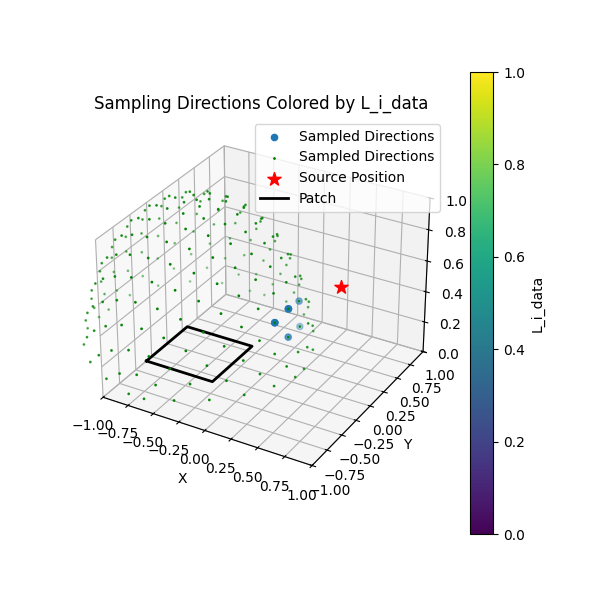

In [26]:
import matplotlib.pyplot as plt
%matplotlib ipympl

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the sampled directions
sc = ax.scatter(
    shifted_coord[collector_idx, 0],
    shifted_coord[collector_idx, 1],
    shifted_coord[collector_idx, 2], cmap='viridis', label='Sampled Directions'
)

ax.scatter(
    shifted_coord[:, 0],
    shifted_coord[:, 1],
    shifted_coord[:, 2], s=1, color='green', cmap='viridis', label='Sampled Directions'
)

# Plot the source position
ax.scatter(
    source_pos[0], source_pos[1], source_pos[2],
    color='red', s=100, marker='*', label='Source Position'
)
# Plot the patch as a rectangle
patch = np.vstack([patch_pts, patch_pts[0]])  # close the loop
ax.plot(patch[:, 0], patch[:, 1], patch[:, 2], color='black', linewidth=2, label='Patch')
ax.legend()
plt.colorbar(sc, ax=ax, label='L_i_data')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Sampling Directions Colored by L_i_data')
plt.show()

#scattering_directions.show()

In [27]:
def point_patch_factor_dblquad_fix(point: np.ndarray, patch_points: np.ndarray, mode='source'):
## Best yet
    N = 2  # quadrature order (adjust for speed/accuracy)
    eps = 1e-12

    edge1 = patch_points[1] - patch_points[0]
    edge2 = patch_points[3] - patch_points[0]
    patch_normal = np.cross(edge1, edge2)
    patch_normal = patch_normal / np.linalg.norm(patch_normal)

    # Ensure normal points toward receiver
    patch_center = np.mean(patch_points, axis=0)
    to_point = point - patch_center
    if np.dot(patch_normal, to_point) < 0:
        patch_normal = -patch_normal

    # Gauss-Legendre nodes/weights on [-1,1]
    u_nodes, u_wts = leggauss(N)
    v_nodes, v_wts = leggauss(N)
    # map nodes/weights to [0,1]
    u = 0.5 * (u_nodes + 1.0)
    v = 0.5 * (v_nodes + 1.0)
    wu = 0.5 * u_wts
    wv = 0.5 * v_wts

    # Create tensor product grid
    U, V = np.meshgrid(u, v, indexing='ij')       # shape (N, N)
    WU, WV = np.meshgrid(wu, wv, indexing='ij')   # shape (N, N)
    W = (WU * WV).ravel()                         # flattened weights

    Uf = U.ravel()
    Vf = V.ravel()

    p0, p1, p2, p3 = patch_points

    # bilinear interpolation weights
    w0 = (1.0 - Uf) * (1.0 - Vf)
    w1 = Uf * (1.0 - Vf)
    w2 = Uf * Vf
    w3 = (1.0 - Uf) * Vf

    # Compute patch sample points (Nsamples, 3)
    patch_pts = (w0[:, None] * p0[None, :]
                 + w1[:, None] * p1[None, :]
                 + w2[:, None] * p2[None, :]
                 + w3[:, None] * p3[None, :])

    # Vector from patch to point
    r_vec = point[None, :] - patch_pts           # (Nsamples,3)
    r_dist = np.linalg.norm(r_vec, axis=1)
    valid = r_dist > eps
    r_dist_safe = np.where(valid, r_dist, 1.0)   # avoid div-by-zero for masked entries
    r_dir = np.zeros_like(r_vec)
    r_dir[valid] = r_vec[valid] / r_dist_safe[valid, None]

    # cos(theta_i)
    cos_theta_i = np.dot(r_dir, patch_normal)

    # Jacobian (dP/du, dP/dv) depend on u,v -> vectorize
    dPdu = (-(1.0 - Vf)[:, None] * p0[None, :]
            + (1.0 - Vf)[:, None] * p1[None, :]
            + Vf[:, None] * p2[None, :]
            - Vf[:, None] * p3[None, :])

    dPdv = (-(1.0 - Uf)[:, None] * p0[None, :]
            - Uf[:, None] * p1[None, :]
            + Uf[:, None] * p2[None, :]
            + (1.0 - Uf)[:, None] * p3[None, :])

    cross = np.cross(dPdu, dPdv)
    dS = np.linalg.norm(cross, axis=1)

    # integrand per sample (mask invalid distances)
    integrand = np.zeros_like(r_dist)
    integrand[valid] = (1.0 / np.pi) * cos_theta_i[valid] * dS[valid] / (r_dist_safe[valid] ** 2)

    # Sum weighted integrand
    result = np.sum(integrand * W)

    if mode == 'source':
        result *= 0.25

    return result

In [28]:
test_patch_point = patch_points_center

test_pt_solution = pt_solution(src_point.cartesian[0], test_patch_point, mode='source')
test_point_patch_factor_dblquad = point_patch_factor_dblquad(src_point.cartesian[0], test_patch_point, mode='source')
test_point_patch_factor_leggaus_planar = point_patch_factor_leggaus_planar(src_point.cartesian[0], test_patch_point, mode='source')
test_point_patch_factor_mc_planar = point_patch_factor_mc_planar(src_point.cartesian[0], test_patch_point, mode='source')
test_point_patch_factor_dblquad_fix = point_patch_factor_dblquad_fix(src_point.cartesian[0], test_patch_point, mode='source')
print(f'test_pt_solution result: {test_pt_solution} ')
print(f'test_point_patch_factor_dblquad result: {test_point_patch_factor_dblquad} ')
print(f'test_point_patch_factor_leggaus_planar result: {test_point_patch_factor_leggaus_planar} ')
print(f'test_point_patch_factor_mc_planar result: {test_point_patch_factor_mc_planar} ')
print(f'test_point_patch_factor_dblquad_fix result: {test_point_patch_factor_dblquad_fix} ')

test_pt_solution result: 0.02543400195644713 
test_point_patch_factor_dblquad result: (0.025434001956447162, 1.9987842839511413e-15) 
test_point_patch_factor_leggaus_planar result: 0.02543385405121559 
test_point_patch_factor_mc_planar result: 0.025434283302228782 
test_point_patch_factor_dblquad_fix result: 0.025418397183844033 
